# Small crystalline dataset Phase Retrieval

> Georgios Varnavides | Jan 12 2025  
>
> Sample: Thin strontium titanate (STO)  
> Sampling conditions: Nyquist  
> Imaging conditions: 20 mrad, in-focus, defocus, coma, defocus + coma  
> Dose conditions: 1e6 and 1e4 e/A2

In [1]:
# %load_ext autoreload 
# %autoreload 2

In [2]:
import quantem as em
import numpy as np

/Users/gvarnavides/Documents/git-repos/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

Import 6D dataset (note first two dimensions are the aberrations axes)

In [3]:
dataset = em.core.io.load("../data/STO_20mrad_C10_C21_Nyquist.zip")
dataset

Dataset(shape=(2, 2, 32, 32, 192, 192), dtype=float32, name='6d dataset')
  sampling: [5.000000e+01 5.000000e+03 1.221875e-01 1.221875e-01 8.391939e-01
 8.391939e-01]
  units: ['A', 'A', 'A', 'A', 'mrad', 'mrad']
  signal units: 'arb. units'

In [4]:
energy = 300e3
semiangle_cutoff = 20

aberrations=[
    [
        {"C10":C10,"C21":C21,"phi21":-0.8}
        for C21 in (0,dataset.sampling[1])
    ]
    for C10 in (0,dataset.sampling[0])
]
aberrations_flat = [aberrations[0][0], aberrations[1][0], aberrations[1][1]]
aberrations_flat

[{'C10': 0, 'C21': 0, 'phi21': -0.8},
 {'C10': np.float64(50.0), 'C21': 0, 'phi21': -0.8},
 {'C10': np.float64(50.0), 'C21': np.float64(5000.0), 'phi21': -0.8}]

## Finite Poisson Dose

In [5]:
def add_poisson_noise(
    dataset,
    electrons_per_area,
):
    if electrons_per_area == np.inf:
        return dataset
    electrons_per_probe = electrons_per_area * dataset.sampling[:2].prod()
    
    dataset_noisy = dataset.copy()
    dataset_noisy.array = np.random.poisson(dataset.array * electrons_per_probe)
    return dataset_noisy

In [6]:
np.random.seed(2025)
noisy_datasets = [
    [
        add_poisson_noise(
            dataset[index],
            dose
        ) for dose in (1e6,1e4)
    ]
    for index in ((0,0),(1,0),(1,1))
]

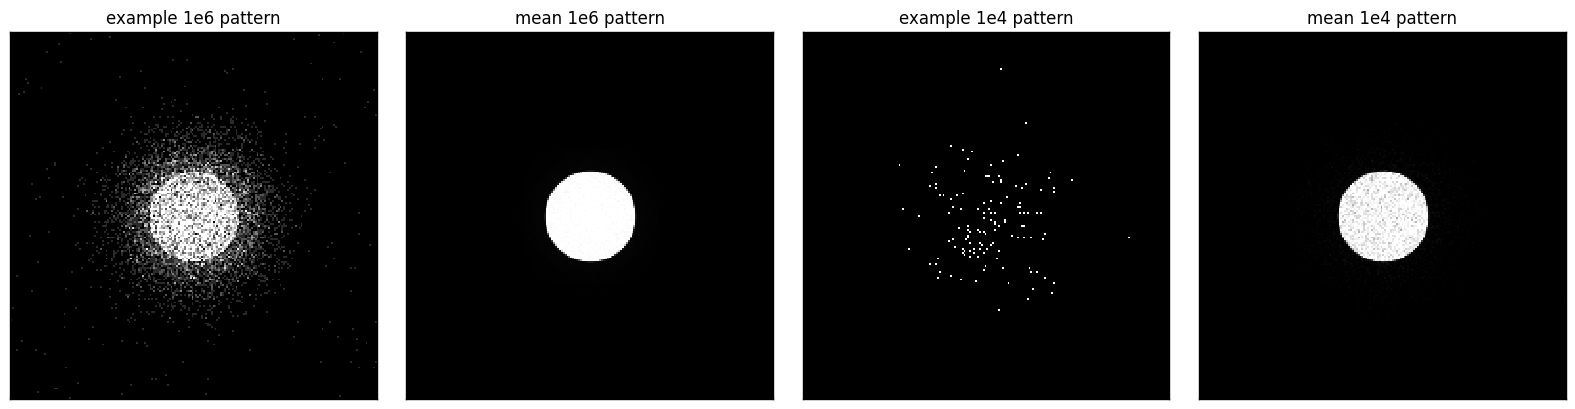

In [7]:
em.visualization.show_2d(
    [
        noisy_datasets[0][0][0,0].array,
        noisy_datasets[0][0].mean((0,1)),
        noisy_datasets[0][1][0,0].array,
        noisy_datasets[0][1].mean((0,1)),
    ],
    title=[
        "example 1e6 pattern","mean 1e6 pattern","example 1e4 pattern","mean 1e4 pattern"
    ]
);

## Direct Ptychography

We start by exploring weak-phase object phase retrieval using the `em.diffractive_imaging.DirectPtychography` class. We make a helper class to initialize a ptycho object for specific datasets.

In [8]:
direct_ptychography_classes = [
    [
        em.diffractive_imaging.DirectPtychography.from_dataset4d(
            x,
            energy=energy,
            semiangle_cutoff=semiangle_cutoff,
            rotation_angle=0,
            aberration_coefs=aberrations_flat[index],
            verbose=False,
            # device='gpu',
        ) for x in sublist
    ] for index,sublist in enumerate(noisy_datasets)
]

### Deconvolution Kernel

Direct ptychography essentially attempts to deconvolve the effect of the probe from the dataset. In quantem, we have implemented five such kernels:
- 'ssb': the double-overlap weighted kernel used in single-sideband direct ptychography
  - 'single-sideband', 'aberration-corrected-bright-field', and 'acbf' are all aliases for 'ssb'
- 'obf': the noise-normalizing optimum bright-field STEM kernel
  - 'optimum-bright-field' is an alias for 'obf'
- 'mf': the least-squares matched-filter kernel (related to Wigner distribution deconvolution)
  - 'matched-filter' is an alias for 'mf'
- 'prlx': the parallax approximation to direct ptychography
  - 'parallax', 'tilt-corrected-bright-field', and 'tcbf' are all aliases for 'prlx'
- 'icom': the first-moment of the gamma kernel in direct ptychography
  - 'center-of-mass' is an alias of 'icom'

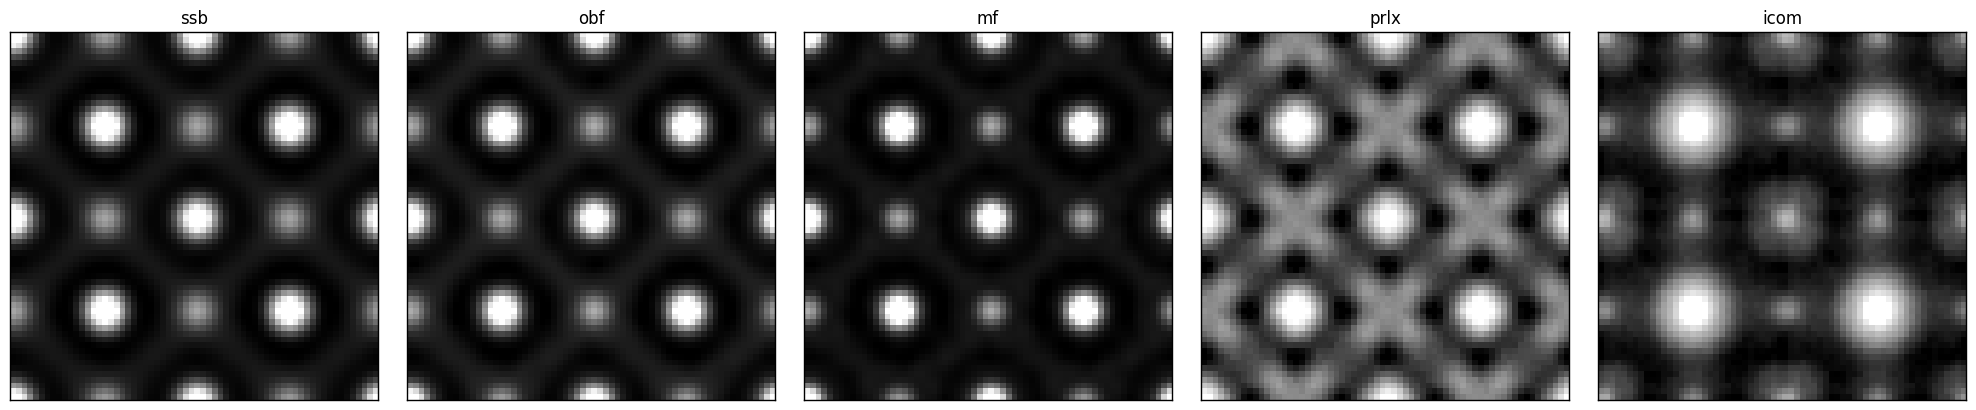

In [9]:
ssb_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='ssb').obj
obf_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='obf').obj
mf_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='mf').obj
parallax_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='parallax').obj
icom_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='icom').obj

em.visualization.show_2d(
    [
        np.tile(ssb_obj,(2,2)),
        np.tile(obf_obj,(2,2)),
        np.tile(mf_obj,(2,2)),
        np.tile(parallax_obj,(2,2)),
        np.tile(icom_obj,(2,2)),
    ],
    title=["ssb","obf","mf","prlx","icom"]
);

### Effect of Aberrations and Dose
These five permutations can be obtained using the convenience wrapper `_reconstruct_all_permutations()`

In [10]:
kwargs = {
    "title":["single-sideband","optimum-bright-field","matched-filter","parallax-imaging","center-of-mass-imaging"],
    "norm":"minmax",
    "axsize":(3,3),
}

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.83it/s]


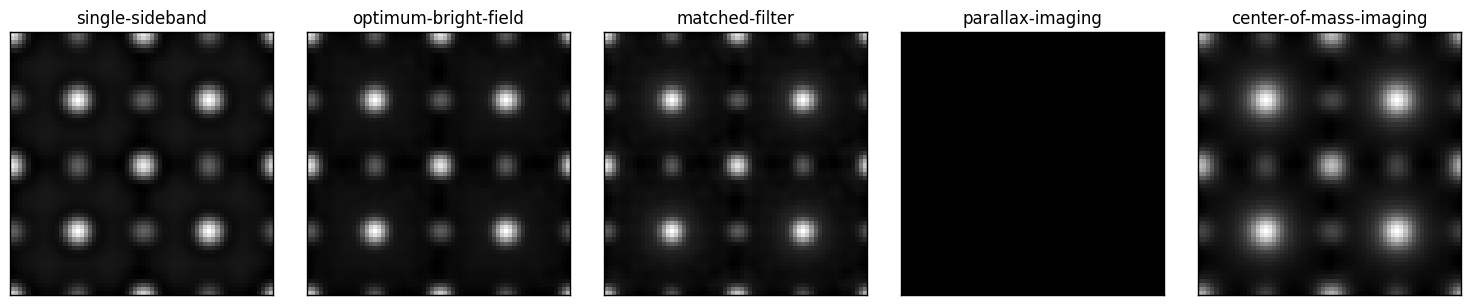

In [11]:
# in-focus, high dose
recons = direct_ptychography_classes[0][0]._reconstruct_all_permutations(verbose=True)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    recons_tiled,
    **kwargs
);

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s]


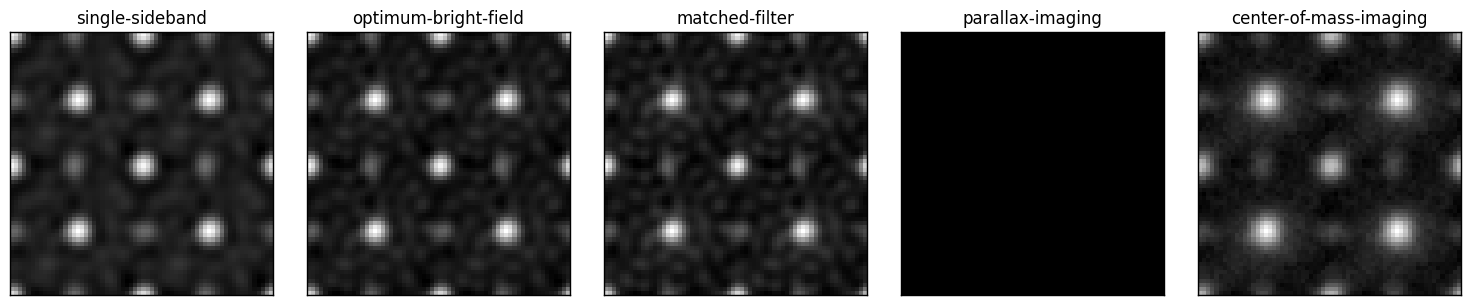

In [12]:
# in-focus, low dose
recons = direct_ptychography_classes[0][1]._reconstruct_all_permutations(verbose=True)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    recons_tiled,
    **kwargs
);

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


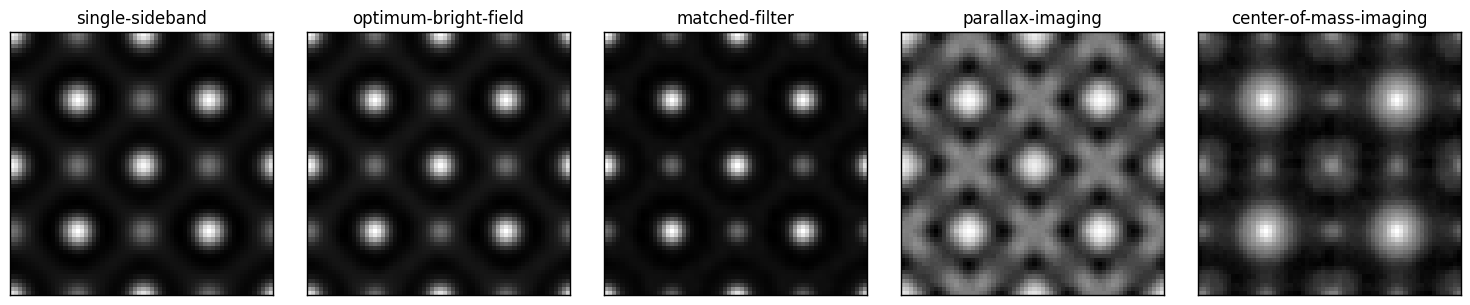

In [13]:
# defocus, high dose
recons = direct_ptychography_classes[1][0]._reconstruct_all_permutations(verbose=True)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    recons_tiled,
    **kwargs
);

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


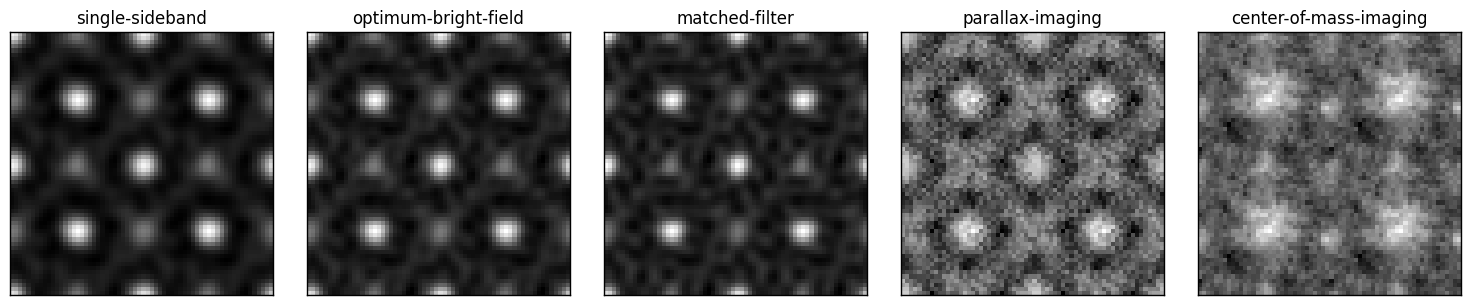

In [14]:
# defocus, low dose
recons = direct_ptychography_classes[1][1]._reconstruct_all_permutations(verbose=True)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    recons_tiled,
    **kwargs
);

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


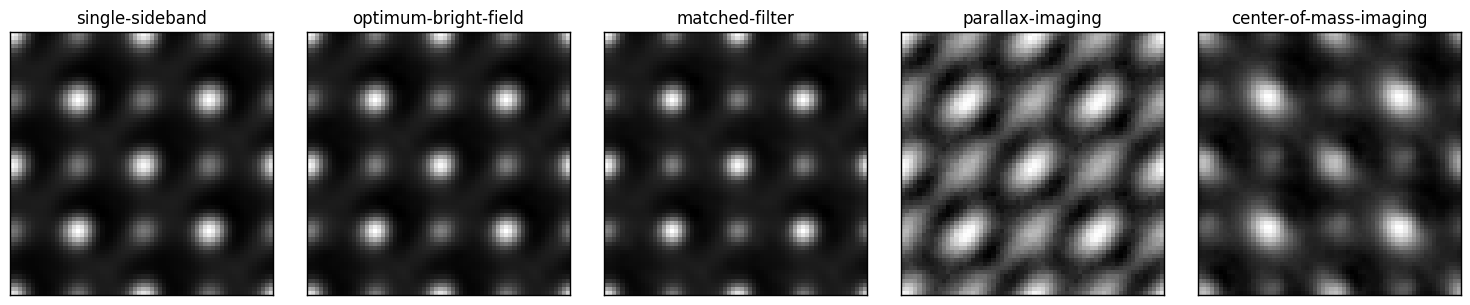

In [15]:
# defocus + coma, high dose
recons = direct_ptychography_classes[2][0]._reconstruct_all_permutations(verbose=True)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    recons_tiled,
    **kwargs
);

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


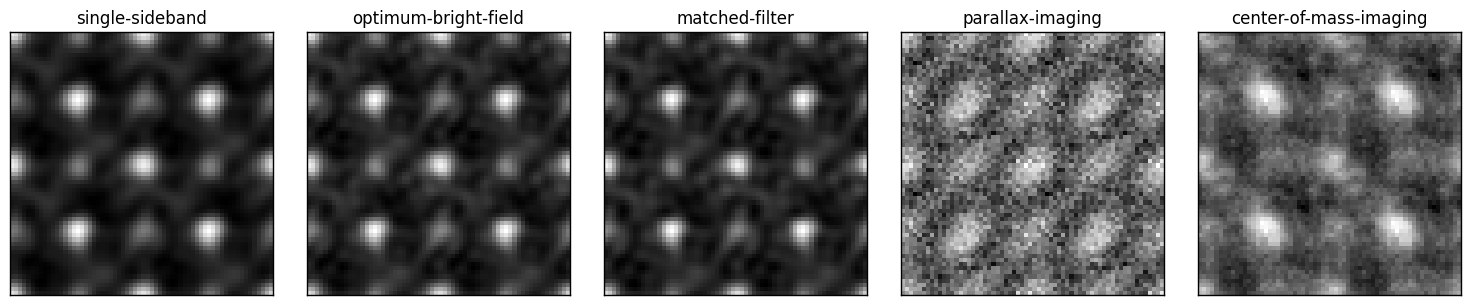

In [16]:
# defocus + coma, low dose
recons = direct_ptychography_classes[2][1]._reconstruct_all_permutations(verbose=True)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    recons_tiled,
    **kwargs
);

### Upsampling

We can also upsample our sub-sampled reconstructions to recover information.  
Note that this does not work for `deconvolution_kernel = 'icom'`

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


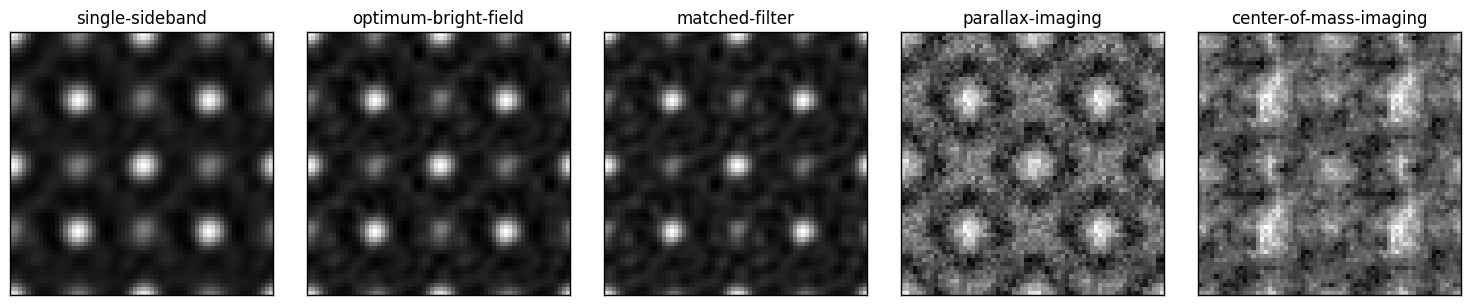

In [17]:
subsampled_noisy_dataset = add_poisson_noise(
    dataset[1,0,::2,::2],
    1e4
)
subsampled_noisy_direct_ptychography_class = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    subsampled_noisy_dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=0,
    aberration_coefs=aberrations_flat[1],
    verbose=False,
    # device='gpu',
)

recons = subsampled_noisy_direct_ptychography_class._reconstruct_all_permutations(
    upsampling_factor=2,
    verbose=True
)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    recons_tiled,
    **kwargs
);

## Parameter Estimation

Above, we used the known simulated aberration coefficients. When these are not known, we provide two main ways to estimate them:
1. Hyperparameter optimization, minimizing the variance across the aligned stack
2. Direct fitting, using either cross-correlation (pairwise or against a reference) or using least-squares fitting of aperture overlaps

Best trial: 102. Best value: 2.99116e-08: 100%|███████████████████████████| 250/250 [00:19<00:00, 13.11it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 50.0, 'C21': 0.0, 'phi21': -0.8},
  initial_rotation_angle=0,
  optimized_aberrations={'C10': 62.47080137643757},
)


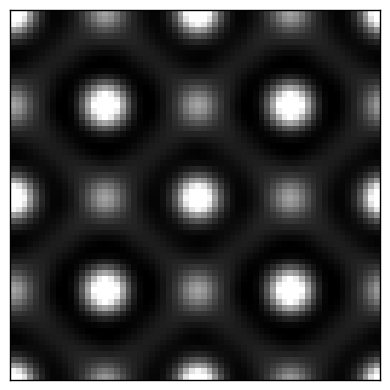

In [18]:
direct_ptychography_classes[1][0].optimize_hyperparameters(
    aberration_coefs={
        "C10":em.diffractive_imaging.direct_ptychography.OptimizationParameter(
            0,200
        )
    },
    n_trials=250,
    deconvolution_kernel='prlx',
    verbose=True,
)

em.visualization.show_2d(
    np.tile(
        direct_ptychography_classes[1][0].reconstruct().obj,
        (2,2)
    )
);

Aligning (reference): 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 50.0, 'C21': 0.0, 'phi21': -0.8},
  initial_rotation_angle=0,
  optimized_aberrations={'C10': -35.91854476928711, 'C12': 11.816545486450195, 'phi12': 0.03776972368359566},
  optimized_rotation_angle=-0.08623743057250977,
)


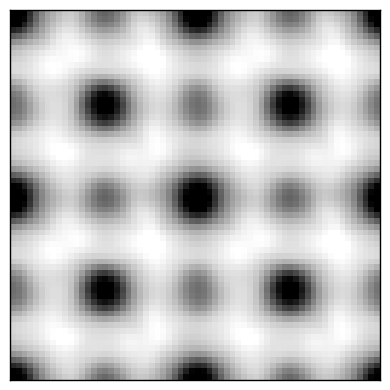

In [25]:
# reference fit from no guess 
direct_ptychography_classes[1][0].fit_hyperparameters_cross_correlation(
    alignment_method='reference',
    bin_factors=(1,1,1),

    aberration_coefs = {"C10":0},
    verbose=True
)

em.visualization.show_2d(
    np.tile(
        direct_ptychography_classes[1][0].reconstruct().obj,
        (2,2)
    )
);

Fitting aberrations: 100%|████████████████████████████████████████| 4/4 [00:01<00:00,  3.85order/s, ['C10']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': 50.0, 'C21': 0.0, 'phi21': -0.8},
  initial_rotation_angle=0,
  optimized_aberrations={'C10': 54.59303665161133, 'C12': 11.816545486450195, 'phi12': 0.037769708782434464},
)


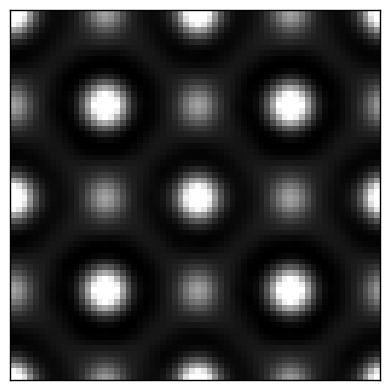

In [26]:
direct_ptychography_classes[1][0].fit_hyperparameters_least_squares(
    aberration_coefs={"C10":0}, # start with zero to show fit
    # cartesian_basis="low_order", # default, ["C10","C12_a","C12_b","C21_a","C21_b","C30"]
    # cartesian_basis=["C10"], # only C10
    cartesian_basis=[["C10"]]*4, # only C10, but recursively refine fit 4 times
    verbose=True,
)

em.visualization.show_2d(
    np.tile(
        direct_ptychography_classes[1][0].reconstruct().obj,
        (2,2)
    )
);

## Iterative Ptychography Comparison

For completeness, we also perform a single-slice iterative ptychography reconstruction.

In [21]:
pdset = em.diffractive_imaging.PtychographyDatasetRaster.from_dataset4dstem(
    subsampled_noisy_dataset
)

pdset.preprocess(
    force_com_rotation=0,
    force_com_transpose=0,
    plot_com=False,
    probe_energy=300e3,
)

Forcing best fit rotation to 0 degrees.
Forcing transpose of intensities to 0.


Normalizing intensities: 100%|██████████████████████████████| 256/256 [00:00<00:00, 1305.50probe position/s]


In [22]:
iterative_ptycho = em.diffractive_imaging.PtychoLite.from_dataset(
    dset=pdset,
    num_slices=1,
    num_probes=1,
    energy=300e3,
    polar_parameters= aberrations_flat[1],
    semiangle_cutoff=20,
    obj_padding_px=(0,0),
).reconstruct(
    num_iters=100,
    # device="gpu",
    batch_size=128
)

Iter 100/100, Loss: 1.570e+02: 100%|██████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


In [23]:
direct_ptycho_phase = subsampled_noisy_direct_ptychography_class.reconstruct(
    upsampling_factor=2
).obj

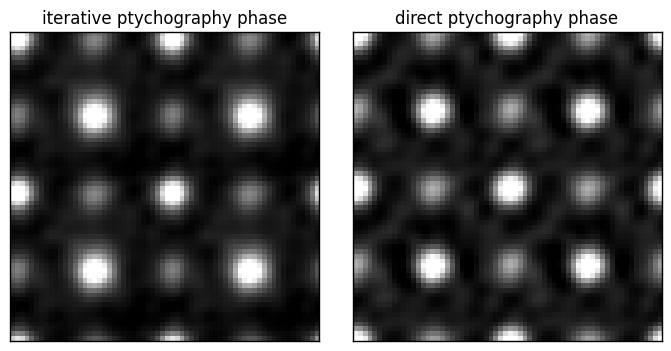

In [24]:
em.visualization.show_2d(
    [
        [
            np.tile(np.angle(iterative_ptycho.obj[0]),(2,2)),
            np.tile(direct_ptycho_phase,(2,2)),
        ],
    ],
    title=[
        ["iterative ptychography phase","direct ptychography phase"],
    ],
    axsize=(3.5,3.5)
);